In [26]:
#code template by Matt Mender, W-2021

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio #allows for importing of .mat files 
import numpy
import time
from torch.utils.data import DataLoader, sampler, TensorDataset 
import torch.nn.functional as F

# If you are using colab, these commands may be helpful
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Import your data here
rootDir = "/content/drive/My Drive/"###Set this to the directory that has the contdata95 file
fn = 'contdata95.mat'

dtype = torch.float
conv_size = 0 # size of time history

# load the mat file
mat = sio.loadmat(rootDir+fn)

# Get each variable from the mat file
X = torch.tensor(mat['Y']) # This is switching Y in the mat file to X in our code - we programmed this with X as the neural data but contdata95.mat has Y as neural data.
#y = torch.tensor(mat['X'])[:,0:4]
y = torch.tensor(mat['X']) 

#X = X[0:10000, 0:95]
#y = y[0:10000, 0:1]

y = y[:, 0:2]

nsamp = X.shape[0]
ntrain = int(numpy.round(nsamp*0.8)) # using 80% of data for training
ntest = int(numpy.round(nsamp*0.9)) # using 90% of data for testing

X_train = X[0:ntrain,:].to(dtype)
#X_test = X[ntrain+1:,:].to(dtype)
X_test = X[ntest+1:,:].to(dtype)
y_train = y[0:ntrain,:].to(dtype)
#y_test = y[ntrain+1:,:].to(dtype)
y_test = y[ntest+1:,:].to(dtype)


# Initialize tensor with conv_size*nfeatures features
#X_ctrain = torch.zeros((int(X_train.shape[0]), int(X_train.shape[1]*conv_size)), dtype=dtype)
#X_ctest = torch.zeros((int(X_test.shape[0]), int(X_test.shape[1]*conv_size)), dtype=dtype)
#X_ctrain[:,0:X_train.shape[1]] = X_train
#X_ctest[:,0:X_test.shape[1]] = X_test
X_ctest = X_test
X_ctrain = X_train
# Add the previous 3 time bins features as a feature in the current time bin
#for k1 in range(conv_size-1):
#    k = k1+1
#    X_ctrain[k:, int(X_train.shape[1]*k):int(X_train.shape[1]*(k+1))] = X_train[0:-k, :]
#    X_ctest[k:, int(X_test.shape[1]*k):int(X_test.shape[1]*(k+1))] = X_test[0:-k, :]

# Create Dataset and dataloader
test_ds= TensorDataset(X_ctest, y_test)
train_ds = TensorDataset(X_ctrain, y_train)

#If a batch in BatchNorm only has 1 sample it wont work, so dropping the last in case that happens
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=True)

In [28]:
X_ctest.shape

torch.Size([3140, 95])

In [29]:
y_test.shape

torch.Size([3140, 2])

In [30]:
X_ctrain.size()

torch.Size([25130, 95])

In [31]:
#batch normalization
#fully connected layer
#dropout
#relu

class myNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_states):
        super().__init__()
        # Define the different layers
        #  Input layer
        self.bn1 = nn.BatchNorm1d(input_size) # batch normalize inputs to fc1
        ####? linear layer
        self.input = nn.Linear(input_size, hidden_size)
        ####? dropout layer
        self.dropout1 = nn.Dropout(0.5)
        
        #  Hidden layer
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.5)     
        #  Output layer
        self.bn3 = nn.BatchNorm1d(hidden_size) 
        self.output = nn.Linear(hidden_size, num_states)
        # Initialization
        nn.init.kaiming_normal_(self.input.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.hidden.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='relu')
        # Your code here

    def forward(self, x):
        # x is your data

        # input layer
        x = self.bn1(x)
        ####? 3 more steps in this layer
        x = self.input(x)
        x = self.dropout1(x) 
        x = F.relu(x)

       # hidden layer
        x = self.bn2(x)
        x = self.hidden(x)
        x = self.dropout2(x) 
        x = F.relu(x)
        # output layer
        x = self.bn3(x)
        x = self.output(x)
        
        #### Your code here
        scores = x ####Point this towards your output linear layer

        return scores

In [32]:
# Specify a model, loss function, and optimizer
weight_decay = 1e-2
learning_rate = 1e-5

#### Your code here for creating the network
theNetwork = myNetwork(95,100,2)

#Define the loss function
loss_fn = nn.MSELoss()

#Define the optimizer
opt = torch.optim.Adam(theNetwork.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [33]:
def myfit(epochs, nntofit, loss_fn, opt, train_dl, val_dl, print_every=1):
    train_loss = torch.zeros(epochs * len(train_dl) , dtype=torch.float) # train error for every iteration
    validation_loss = torch.zeros(epochs , dtype=torch.float) # validation is only once per epoch
    i = -1 # iteration number
    for epoch in range(epochs):
        
        for x,y in train_dl: # batch of training points
            i += 1
            # Set model in train mode (for batch normalization and dropout)
            nntofit.train()
            
            # 1. Generate your predictions by running x through the network
            yh = theNetwork(x) ####?
        
            # 2. Find Loss by comparing predicted and actual using loss function
            loss = loss_fn(yh,y) ####?
            
            # 3. Calculate gradients with respect to weights/biases 
            loss.backward()####?
            train_loss[i] = loss.item() #Keep track of loss on training data
        
            # 4. Adjust your weights by taking a step forward on the optimizer
            opt.step() 
            
            # 5. Reset the gradients to zero on the optimizer
            opt.zero_grad()
            
        #Validation accuracy
        for xval,yval in val_dl:
            with torch.no_grad(): # disable gradient calculation
                nntofit.eval() # set model to evaluation mode (matters for batch normalization and dropout)
                loss2 = loss_fn(nntofit(xval),yval)
                validation_loss[epoch] = loss2.item()
    return train_loss, validation_loss

In [34]:
start_time = time.time()
# Train the network
n_epochs = 30 ####?
train_loss, validation_loss = myfit(n_epochs, theNetwork, loss_fn, opt, train_dl, test_dl)
print("--- %s seconds ---" % (time.time() - start_time))

--- 44.913453340530396 seconds ---


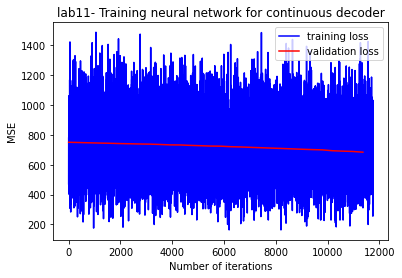

In [35]:
# Plot training and validation losses
plot_epochs = n_epochs

val_iters = numpy.arange(0,n_epochs)*len(train_dl)
train_iters = numpy.arange(0,len(train_dl)*n_epochs)
n_iter = len(train_dl) * n_epochs # number of batches per epoch * number of epochs 

plt.plot(train_iters[0:plot_epochs*len(train_dl)], train_loss[0:plot_epochs*len(train_dl)], 'b', label="training loss")
plt.plot(val_iters[0:plot_epochs], validation_loss[0:plot_epochs], 'r', label="validation loss")
plt.xlabel('Number of iterations')
plt.ylabel('MSE')
plt.title("lab11- Training neural network for continuous decoder")
plt.legend()
plt.show()

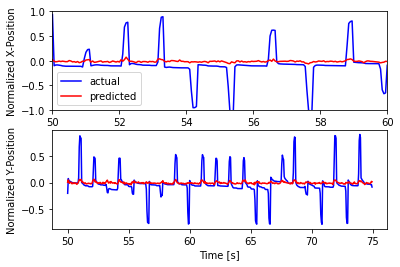

Correlation for X position is 0.219747
Correlation for Y position is 0.0439921


In [38]:
# Plot some example decodes
for x,y in test_dl:
    with torch.no_grad():
        yh = theNetwork(x)
        #looking at select channel
    th = numpy.arange(0, x.shape[0])*50e-3
    
    y[:,0] = y[:,0]/100
    yh[:,0] = yh[:,0]/100

    y[:,1] = y[:,1]/100
    yh[:,1] = yh[:,1]/100

    plt.subplot(2,1,1)
    plt.plot(th[1000:1500], y[1000:1500,0],'b', label="actual")
    plt.plot(th[1000:1500],yh[1000:1500,0].detach().numpy(), 'r', label="predicted")
    plt.legend()
    #plt.xlabel('sec')
    #plt.title("Example decode of the trained continuous decoder using ANN")
    plt.ylabel('Normalized X-Position')
    plt.ylim([-1,1])
    plt.xlim([50,60])
    plt.subplot(2,1,2)
    plt.plot(th[1000:1500], y[1000:1500,1], 'b', label="actual")
    plt.plot(th[1000:1500],yh[1000:1500,1].detach().numpy(), 'r', label="predicted")
    plt.xlabel('Time [s]')
    plt.ylabel('Normalized Y-Position')

    
    plt.show()
    
    r = numpy.corrcoef(yh.detach().numpy().T,y.T)
    #r = numpy.diag(r[4:,0:4])
    r = numpy.diag(r[1:,0:2])
    print('Correlation for X position is %g' % r[0])
    print('Correlation for Y position is %g' % r[1])
    #print('Correlation for X velocity is %g' % r[2])
    #print('Correlation for Y velocity is %g' % r[3])
    #print('Average Correlation: %g' % numpy.mean(r))